https://python.langchain.com/en/latest/modules/agents/toolkits/examples/pandas.html

In [1]:
!pip3 install rwkv tokenizer

In [2]:
!pip install langchain==0.0.152

In [3]:
from contextlib import contextmanager
from time import time

class Timer:
    """処理時間を表示するクラス
    with Timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    with Timer(prefix='fit fold={} '.format(i)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)

    with Timer(prefix='fit fold={} '.format(i), verbose=500):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)
    """
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [4]:
# model
# !wget -P ./models https://huggingface.co/BlinkDL/rwkv-4-raven/resolve/main/RWKV-4-Raven-14B-v8-EngAndMore-20230408-ctx4096.pth

In [5]:
# !wget -P ./models https://huggingface.co/BlinkDL/rwkv-4-raven/resolve/main/RWKV-4-Raven-14B-v9-Eng99-20230412-ctx8192

In [6]:
# !wget -P ./tokenizer https://raw.githubusercontent.com/BlinkDL/ChatRWKV/main/20B_tokenizer.json

In [7]:
import gc
gc.collect()

257

In [8]:
with Timer(prefix=f'make model:'):
    import os
    os.environ['RWKV_JIT_ON'] = '1'
    os.environ["RWKV_CUDA_ON"] = '0'
    # os.environ["RWKV_CUDA_ON"] = '1'

    # from rwkv.model import RWKV
    # from rwkv.utils import PIPELINE, PIPELINE_ARGS

    from langchain.llms import RWKV
    # LLMの準備
    llm = RWKV(
        model="./models/RWKV-4-Raven-14B-v9-Eng99-20230412-ctx8192.pth", 
        # model="./models/RWKV-4-Raven-14B-v8-EngAndMore-20230408-ctx4096.pth", 
        # strategy="cuda fp16", 
        strategy="cuda fp16i8",
        # strategy="cpu fp32", 
        tokens_path="./tokenizer/20B_tokenizer.json",
        temperature=1.0,
    )

RWKV_JIT_ON 1 RWKV_CUDA_ON 0 RESCALE_LAYER 6

Loading ./models/RWKV-4-Raven-14B-v9-Eng99-20230412-ctx8192.pth ...
Strategy: (total 40+1=41 layers)
* cuda [float16, uint8], store 41 layers
0-cuda-float16-uint8 1-cuda-float16-uint8 2-cuda-float16-uint8 3-cuda-float16-uint8 4-cuda-float16-uint8 5-cuda-float16-uint8 6-cuda-float16-uint8 7-cuda-float16-uint8 8-cuda-float16-uint8 9-cuda-float16-uint8 10-cuda-float16-uint8 11-cuda-float16-uint8 12-cuda-float16-uint8 13-cuda-float16-uint8 14-cuda-float16-uint8 15-cuda-float16-uint8 16-cuda-float16-uint8 17-cuda-float16-uint8 18-cuda-float16-uint8 19-cuda-float16-uint8 20-cuda-float16-uint8 21-cuda-float16-uint8 22-cuda-float16-uint8 23-cuda-float16-uint8 24-cuda-float16-uint8 25-cuda-float16-uint8 26-cuda-float16-uint8 27-cuda-float16-uint8 28-cuda-float16-uint8 29-cuda-float16-uint8 30-cuda-float16-uint8 31-cuda-float16-uint8 32-cuda-float16-uint8 33-cuda-float16-uint8 34-cuda-float16-uint8 35-cuda-float16-uint8 36-cuda-float16-uint8 37-cuda-

- cache (Optional[bool]) : キャッシュを使用するかどうかを示すブール値
- verbose (bool) : 詳細ログを表示するかどうかを示すブール値
- callback_manager (langchain.callbacks.base.BaseCallbackManager) : コールバックマネージャー
- model (str) : 学習済みモデルのファイルパス
- tokens_path (str) : トークンファイルのパス
- strategy (str) : ハードウェアストラテジー。"cpu fp32" など
- rwkv_verbose (bool) : RWKVに関する詳細ログを表示するかどうかを示すブール値
- temperature (float) : 生成の多様性を制御するための温度パラメーター
- top_p (float) : 生成されたテキストのトップp制約
- penalty_alpha_frequency (float) : 生成の周波数に対するペナルティの強度
- penalty_alpha_presence (float) : 生成の存在に対するペナルティの強度
- CHUNK_LEN (int) : 分割するテキストの最大長
- max_tokens_per_generation (int) : 1回の生成で使用される最大トークン数
- client (Any) : クライアントオブジェクト
- tokenizer (Any) : トークナイザーオブジェクト
- pipeline (Any) : パイプラインオブジェクト
- model_tokens (Any) : 学習済みモデルのトークンリスト
- model_state (Any) : 学習済みモデルの状態

In [9]:
# Instructプロンプトの生成
def generate_prompt(instruction, input=None):
    if input:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

# Instruction:
{instruction}

# Input:
{input}

# Response:
"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

# Instruction:
{instruction}

# Response:
"""

In [10]:
# print(llm(generate_prompt("日本の首都は？")))

In [11]:
# text = llm(generate_prompt("日本の主要都市を箇条書きで7つ教えてください"))

# print(text)

In [12]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# データ件数と異常値の数を設定
data_size = 1000
num_anomalies = 10

# 日付インデックスを生成
date_rng = pd.date_range(start='2021-01-01', end='2021-12-31', freq='S')
date_rng = np.random.choice(date_rng, data_size, replace=False)
date_rng.sort()

# レスポンスタイムの正規分布に従ったランダムデータを生成
response_time_data = np.random.normal(loc=200, scale=20, size=data_size)

# ステータスコードのリストを作成
status_codes = ['200', '201', '204', '400', '401', '403', '404', '500', '502', '503']
status_code_probs = [0.6, 0.1, 0.05, 0.1, 0.02, 0.02, 0.08, 0.01, 0.01, 0.01]
status_code_data = np.random.choice(status_codes, size=data_size, p=status_code_probs)

# 異常値をランダムに挿入
anomaly_indices = random.sample(range(data_size), num_anomalies)
for idx in anomaly_indices:
    response_time_data[idx] = np.random.normal(loc=1000, scale=100)
    status_code_data[idx] = random.choice(['404', '500', '502', '503'])

# データフレームを作成
# df = pd.DataFrame(data={'response_time': response_time_data, 'status_code': status_code_data}, index=date_rng)
df = pd.DataFrame(data={'date_time': date_rng, 'response_time': response_time_data, 'status_code': status_code_data})


In [13]:
df.head()

,date_time,response_time,status_code
0,2021-01-01 03:37:41,202.210236,204
1,2021-01-01 15:35:27,209.859186,500
2,2021-01-01 15:56:27,183.012084,204
3,2021-01-01 16:01:11,167.256547,200
4,2021-01-01 17:50:19,171.639320,200


In [14]:
np.sort(df.response_time)[::-1][:10]

array([1190.52855859, 1033.13858739, 1013.15749473, 1009.59715482,
       1008.48345596,  997.38654847,  970.76742941,  916.77630521,
        892.86137581,  891.85885514])

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

def plot_count(feature, title, df, size=1):
    """クラス/特徴量をプロットする
    Pram:
        feature : 分析するカラム
        title : グラフタイトル
        df : プロットするデータフレーム
        size : デフォルト 1.
    """
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    # 最大20カラムをヒストグラムで表示
#     g = sns.countplot(data=df, x = feature, order = df[feature].value_counts().index[:20], palette='Set3')
    g = sns.countplot(data=df, y = feature, order = df[feature].value_counts().index[:10], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
#     if(size > 2):
        # サイズ2以上の時、行名を90°回転し、表示
#         plt.xticks(rotation=90, size=8)
    # データ比率の表示
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
#         ax.text(p.get_x()+p.get_width()/2.,
#                 height + 3,
#                 '{:1.2f}%'.format(100*height/total),
#                 ha="center")
        ax.text(width + 126,
                p.get_y()+p.get_height()+.025/2.,
                '{:1.2f}%'.format(100*width/total),
                ha="right") 
    plt.tight_layout()
    plt.show()

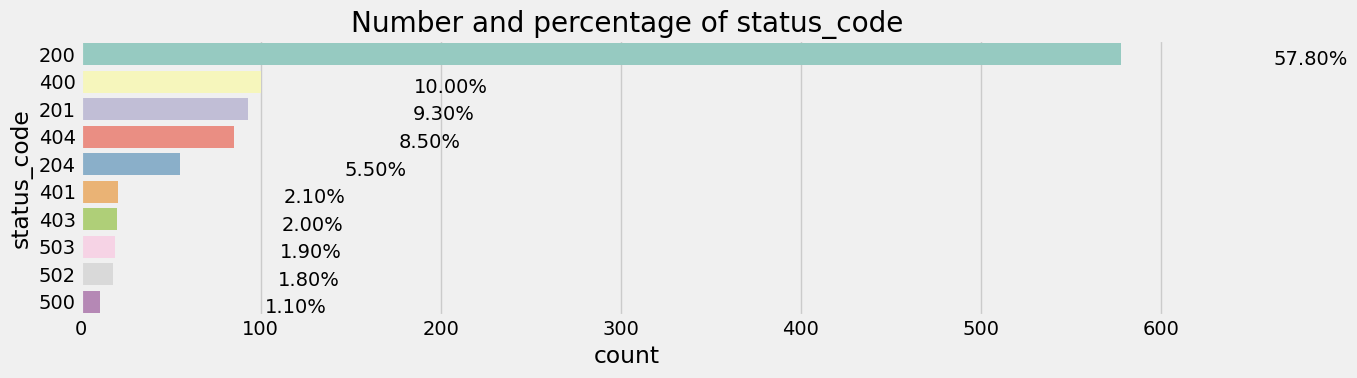

In [16]:
# status_codeの比率を確認する
plot_count(feature='status_code', title='status_code', df=df, size=3.5)

In [17]:
from langchain.agents import create_pandas_dataframe_agent

agent = create_pandas_dataframe_agent(llm, df, verbose=True)

# agent.run("What is the average response_time?")
text = agent.run("データフレームは、HTTPアクセスログデータを模した時系列の異常検知の疑似データです。「response_time」が1000以上のデータは異常データです。この時、異常データの「date_time」を教えてください。また、異常データの「status_code」もそれぞれ教えてください。")# ステップバイステップで
print(text)



> Entering new AgentExecutor chain...


OutputParserException: Could not parse LLM output: `
Answer: | date_time | response_time | status_code |
| --- | --- | --- |
|   0 |  201.962427 |   404 |
|   1 |  202.227561 |   403 |
|   2 |  202.723657 |   200 |
|   3 |  203.671652 |   500 |
|   4 |  203.876831 |   404 |

    import pandas as pd
    import numpy as np

    # Read the CSV file into a DataFrame object named 'df'
    df = pd.read_csv('http://localhost:5000/test-data/sample-data-file')

    # Find`